In [1]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools
import pyLDAvis
import pyLDAvis.gensim #dont skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


### BBC News Dataset

### Preprocessing

1. Tokenize each review (using gensim)
2. Remove stop words (including punctuations)
3. Lemmatize (using spacy)


In [37]:
# Reading the BBC news dataset
data_folder="../input/bbc-news-summary/BBC News Summary/News Articles"
folders=["business","entertainment","politics","sport","tech"]
x=[]
y=[]


for i in folders:
    files=os.listdir(data_folder+'/'+i)
    for text_file in files:
        file_path=data_folder + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        x.append(data)
        y.append(i)
        
data={'news':x,'type':y}
df = pd.DataFrame(data)
df.to_csv('bbc_data.csv', index=False)        

In [38]:
df.head()

,news,type
0,b'US consumer confidence up\n\nConsumers\' con...,business
1,b'The \'ticking budget\' facing the US\n\nThe ...,business
2,"b""Mitsubishi in Peugeot link talks\n\nTrouble-...",business
3,b'BMW reveals new models pipeline\n\nBMW is pr...,business
4,b'World leaders gather to face uncertainty\n\n...,business


In [39]:
df.type.astype('category').value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [40]:
# filter business articles
df = df[df['type']=='business']
df.shape

(510, 2)

In [41]:
# convert to list
data=df['news'].values.tolist()
data_words=list(sent_to_words(data))

# remove stop words
data_words_nostops= remove_stopwords(data_words)

#lemmatize
nlp = spacy.load('en', disable=['parser','ner'])
data_lemmatized = lemmatization(data_words_nostops,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



## Creating Dictionary and Corpus

`Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.`

In [ ]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Building the Topic Model


In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## Computing coherence score


In [43]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4499446504324448


In [44]:
# print keywords
pprint(lda_model.print_topics())


[(0,
  '0.022*"gorge" + 0.019*"dam" + 0.016*"environmental" + 0.008*"power" + '
  '0.007*"mandatory" + 0.006*"sand" + 0.005*"draw" + 0.000*"sepa" + '
  '0.000*"downstream" + 0.000*"chronic"'),
 (1,
  '0.030*"develop" + 0.023*"unfair" + 0.020*"nationwide" + 0.019*"customer" + '
  '0.019*"decision" + 0.017*"position" + 0.016*"insurance" + 0.016*"private" + '
  '0.015*"find" + 0.014*"evidence"'),
 (2,
  '0.023*"company" + 0.020*"airline" + 0.020*"case" + 0.018*"oil" + '
  '0.017*"court" + 0.015*"russian" + 0.014*"claim" + 0.014*"unit" + '
  '0.013*"state" + 0.013*"sale"'),
 (3,
  '0.088*"card" + 0.071*"volume" + 0.032*"equip" + 0.026*"credit" + '
  '0.021*"creditor" + 0.014*"consortium" + 0.012*"buying" + 0.012*"rescue" + '
  '0.011*"train" + 0.011*"bubble"'),
 (4,
  '0.013*"impetus" + 0.012*"minute" + 0.008*"tube" + 0.008*"reap" + '
  '0.007*"reading" + 0.005*"wharf" + 0.003*"crossrail" + 0.001*"proximity" + '
  '0.001*"provided" + 0.001*"treasury"'),
 (5,
  '0.000*"appear" + 0.000*"wron

In [45]:
doc_lda = lda_model[corpus]


## Visualize the topics


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.244425 -0.046253       1        1  28.651353
18     0.249304  0.049701       2        1  11.569925
10     0.288971 -0.197095       3        1  10.862863
11     0.204021  0.149917       4        1  10.518417
12     0.244651 -0.216842       5        1   9.264144
2      0.189019  0.186206       6        1   8.826582
7      0.136375 -0.055649       7        1   5.764434
15     0.059587  0.143193       8        1   4.470297
8     -0.016003  0.046070       9        1   3.064543
1     -0.011154  0.153504      10        1   2.875692
16    -0.087373  0.109205      11        1   1.565822
14    -0.146532  0.000770      12        1   0.633784
6     -0.149859 -0.062019      13        1   0.504358
3     -0.171021 -0.042845      14        1   0.503218
9     -0.176877 -0.040837      15        1   0.271552
17    -0.177773 -0.039553      16        1   0.265884
13    -0.175532 -0.041670      17        1   0.249283
0     -0.169522 -0.032406      18        1   0.069654
4     -0.168936 -0.033116      19        1   0.059859
5     -0.165772 -0.030280      20        1   0.008336, topic_info=             Term        Freq       Total Category  logprob  loglift
641         price  491.000000  491.000000  Default  30.0000  30.0000
833           oil  269.000000  269.000000  Default  29.0000  29.0000
364          firm  465.000000  465.000000  Default  28.0000  28.0000
57           rise  483.000000  483.000000  Default  27.0000  27.0000
487       country  366.000000  366.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2070      partner    0.000925   14.767721  Topic20  -8.7389  -0.2856
2058        sweet    0.000925    1.957764  Topic20  -8.7389   1.7350
2049     gasoline    0.000925    2.766895  Topic20  -8.7389   1.3891
2050  instability    0.000925    2.583935  Topic20  -8.7389   1.4575
2051   mechanical    0.000925    0.763147  Topic20  -8.7389   2.6771

[1036 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2077      2  0.809550      absorb
1264      8  0.991108      accept
2508     12  0.589412  accomodate
0         1  0.846439      accord
0         3  0.066824      accord
...     ...       ...         ...
73        6  0.054120        year
73        7  0.114660        year
73        8  0.004586        year
73       10  0.000917        year
1723      5  0.992735         yen

[1564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 11, 12, 13, 3, 8, 16, 9, 2, 17, 15, 7, 4, 10, 18, 14, 1, 5, 6])

## Hyperparameter Tuning - Number of Topics and Alpha



In [47]:
# build models across a range of num_topics and alpha
num_topics_range=[2,6,10,15]
alpha_range=[0.01,0.1,1]
model_list, coherence_values=compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                      num_topics_range=num_topics_range,\
                                                     alpha_range=alpha_range)
coherence_df=pd.DataFrame(coherence_values,columns=['alpha','num_topics','coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.307777
1,0.01,6,0.294715
2,0.01,10,0.300718
3,0.01,15,0.284745
4,0.10,2,0.297096
5,0.10,6,0.307790
6,0.10,10,0.295126
7,0.10,15,0.300221
8,1.00,2,0.295729
9,1.00,6,0.307726


## Coherence plots

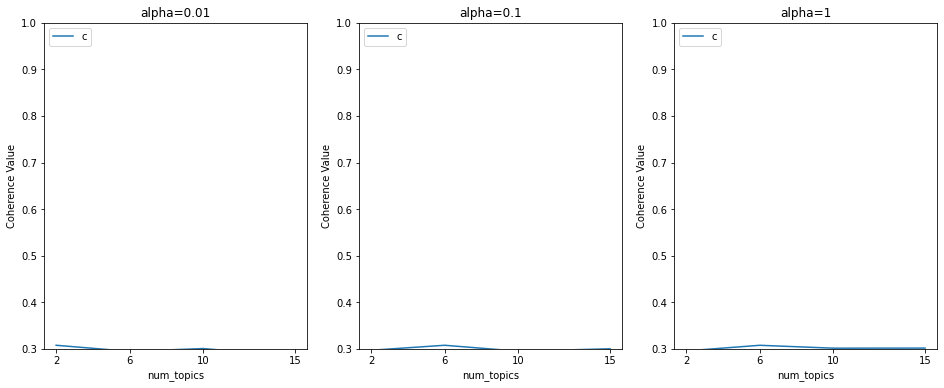

In [48]:
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)